In [248]:
# !pip install eurostat
# !pip uninstall xgboost
# !pip install scikit-learn
# !pip install mango
# !pip install arm-mango
# !pip install pmdarima
# !pip install joblib
# !pip install arch

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import eurostat
import numpy as np
from tqdm import tqdm
from pmdarima.arima import auto_arima
import warnings

import xgboost as xgb
from sklearn.metrics  import mean_squared_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.model_selection import GridSearchCV

from joblib import Parallel
from joblib import delayed
from os import cpu_count

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

# Ethanol Trade - Price - Germany Imports

From EDA Trade

# EDA - Time Series Analysis

In [3]:
df = pd.read_pickle('ts_ethanol_price.pickle')
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ts_ethanol_price.pickle'

In [8]:
#df.OBS_VALUE = df.OBS_VALUE.astype(int)
df.index = pd.to_datetime(df.index)
df.name = "OBS_VALUE"
df

TIME_PERIOD
1988-01-01    0.537089
1988-02-01    0.479692
1988-03-01    0.530828
1988-04-01    0.512240
1988-05-01    0.483517
                ...   
2022-12-01    1.090180
2023-01-01    1.117564
2023-02-01    1.167001
2023-03-01    1.298366
2023-04-01    1.186485
Name: OBS_VALUE, Length: 424, dtype: float64

<Axes: title={'center': 'Price of Ethanol (€/kg) Germany Imports'}, xlabel='TIME_PERIOD'>

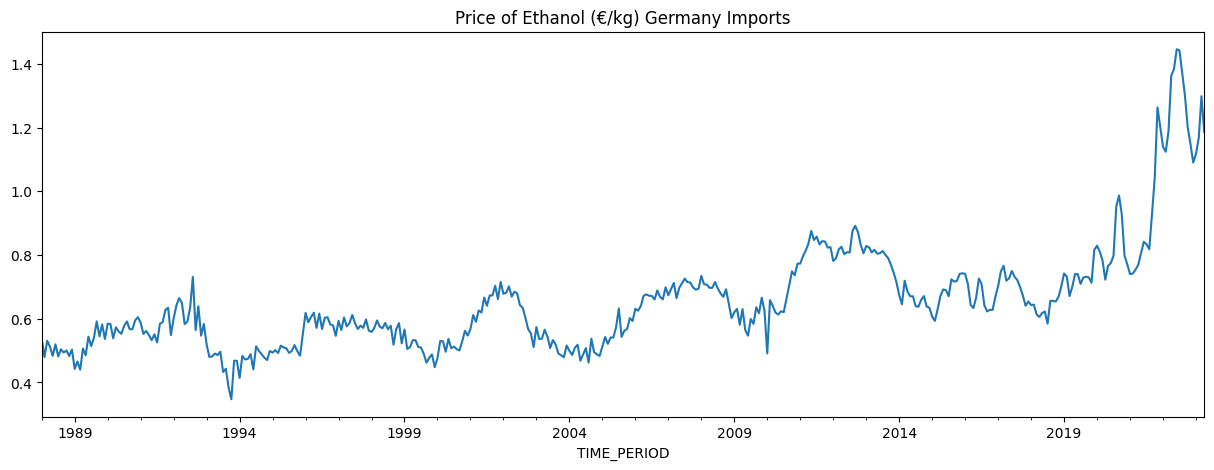

In [6]:
df.plot(style='-', figsize=(15,5), title = "Price of Ethanol (€/kg) Germany Imports")

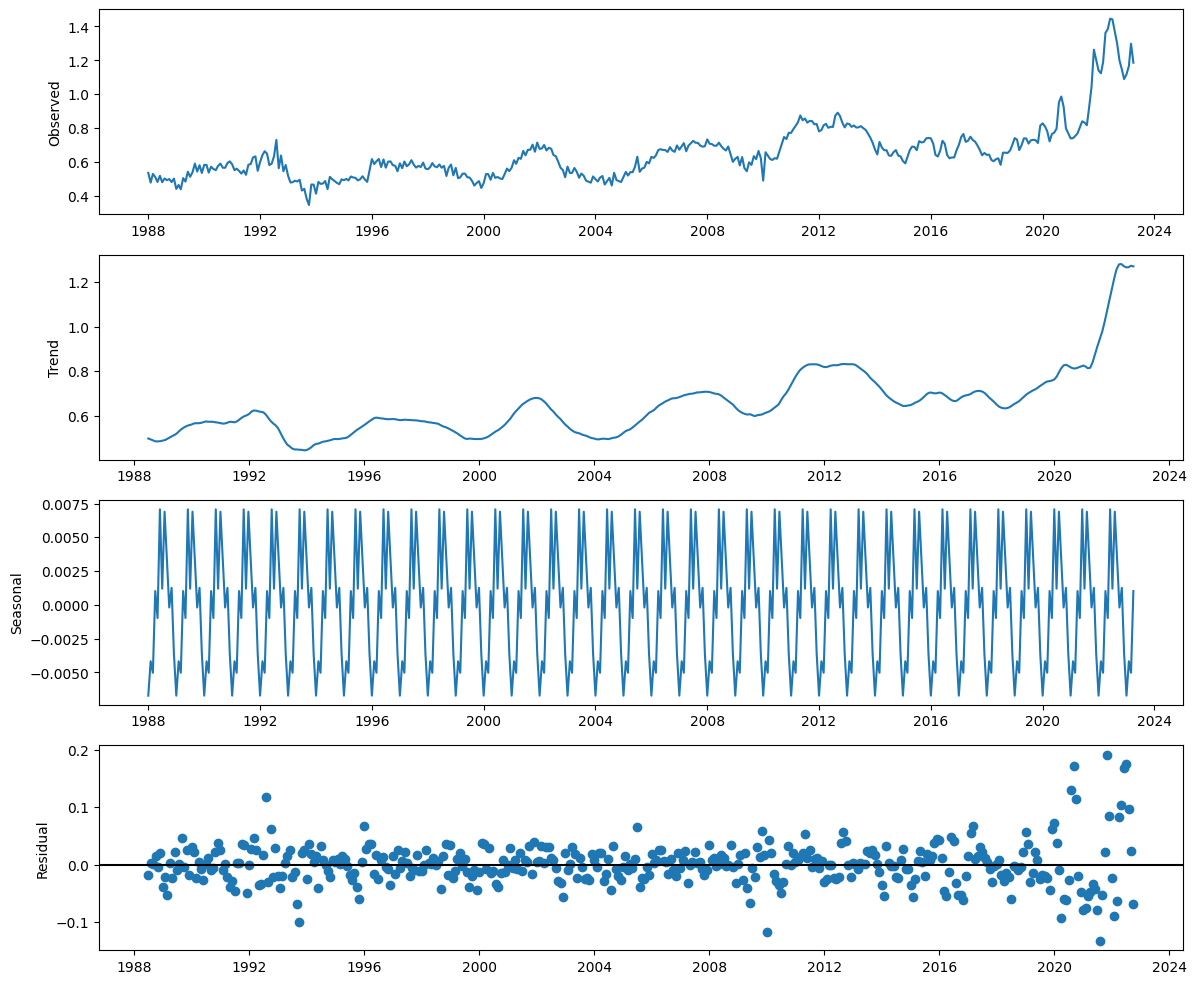

In [14]:
def plot_trend_decomposition(df, model = "additive"):
    # Decomposing the time series
    result = seasonal_decompose(df, model)

    # Getting the figure and axes objects
    fig, axes = plt.subplots(nrows=4, figsize=(12, 10))

    # Plotting the observed, trend, seasonal, and residual components
    axes[0].plot(df.index, df.values)
    axes[0].set_ylabel('Observed')
    axes[1].plot(result.trend.index, result.trend)
    axes[1].set_ylabel('Trend')
    axes[2].plot(result.seasonal.index, result.seasonal)
    axes[2].set_ylabel('Seasonal')
    axes[3].axhline(0, color='black', linestyle='-') # Adding a horizontal line at y=0
    axes[3].scatter(result.resid.index, result.resid)
    axes[3].set_ylabel('Residual')

    plt.tight_layout()

    plt.show()
    
plot_trend_decomposition(df
                         #, model="multiplicative"
                        )

## Interpretations

* Trend:
    * No trends = stationary
    * Linear Trend = no transgformations needed for the application of linear models
    * Non-Linear Trend = apply transformations (log, sqrt, etc.) or use non-linear models/ regression
* Seasonality:
    * If there is seasonality incorporate it in the forecast model
* Residuals:
    * Residuals should be random and close to zero (constant variaton). If not, it indicates a violation of the assumption of constant variance (homoscedasticity) in the time series
    * Aplly Transformations, wieghet least squares, time segmentation, GARCH models
 

In [15]:
def seasonality(df, model = "additive"):
    decompose = seasonal_decompose(df, model = model)
    i = 1
    period = i
    while i < len(decompose.seasonal):
        if round(decompose.seasonal[i], 10) == round(decompose.seasonal[0], 10):
            period = i
            i = len(decompose.seasonal)
        i = i + 1
    
    if period != i:
        return period
    else:
        return "No seasonality"
    
period = seasonality(df
                     #, model = "multiplicative"
                    )
period

12

## Is the Time Series Stationary?

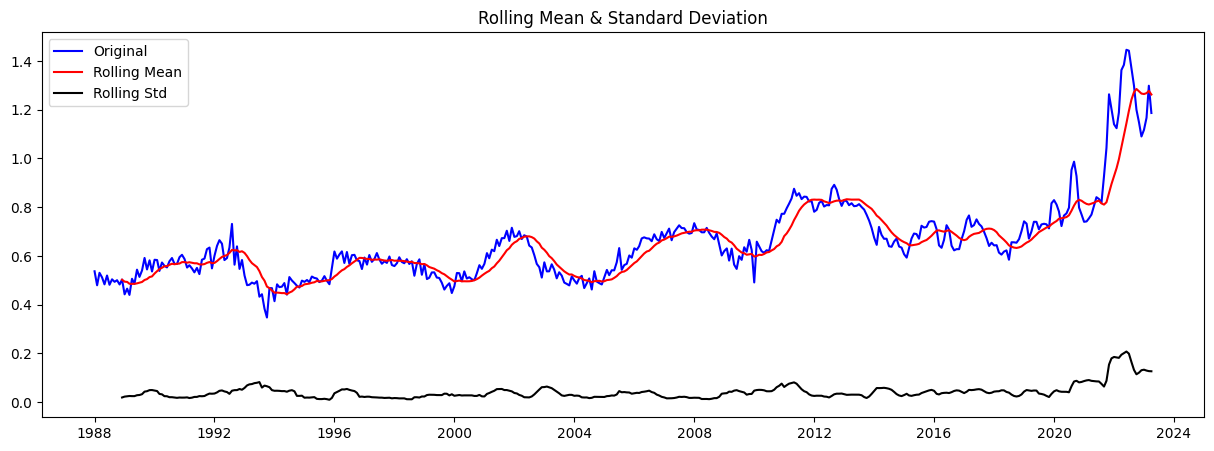

ADF Statistic: -0.8543087525023954
p-value: 0.8026467571723863
Critical Values:
	1%: -3.4460914174990296
	5%: -2.868479374038333
	10%: -2.570466459559076


In [189]:
def get_stationarity(timeseries, y = 'OBS_VALUE'):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    fig, ax = plt.subplots(1, figsize=(15,5))
    
    # rolling statistics plot
    original = ax.plot(timeseries, color='blue', label='Original')
    mean = ax.plot(rolling_mean, color='red', label='Rolling Mean')
    std = ax.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries.values)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
               
get_stationarity(df)

not stationarary

### "Stationarizing the data"
Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases. 

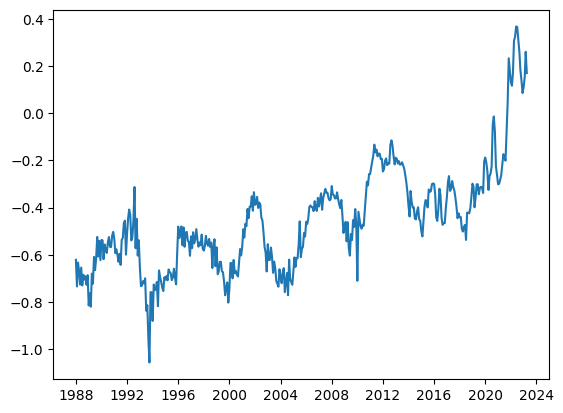

In [19]:
df_log = np.log(df)
plt.plot(df_log)

Then we can test different data ransformatons to "stationarize the data":
1. Subtracting the rolling mean
2. Exponential decay
3. Time shifting

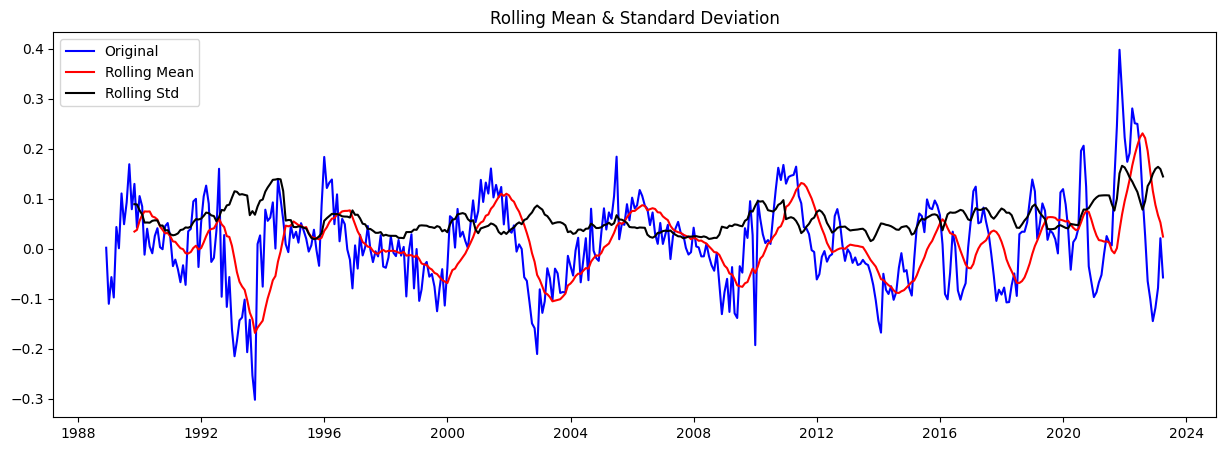

ADF Statistic: -6.389810235670896
p-value: 2.119624704456933e-08
Critical Values:
	1%: -3.4466811208382437
	5%: -2.8687386420385494
	10%: -2.5706046655665635


In [20]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

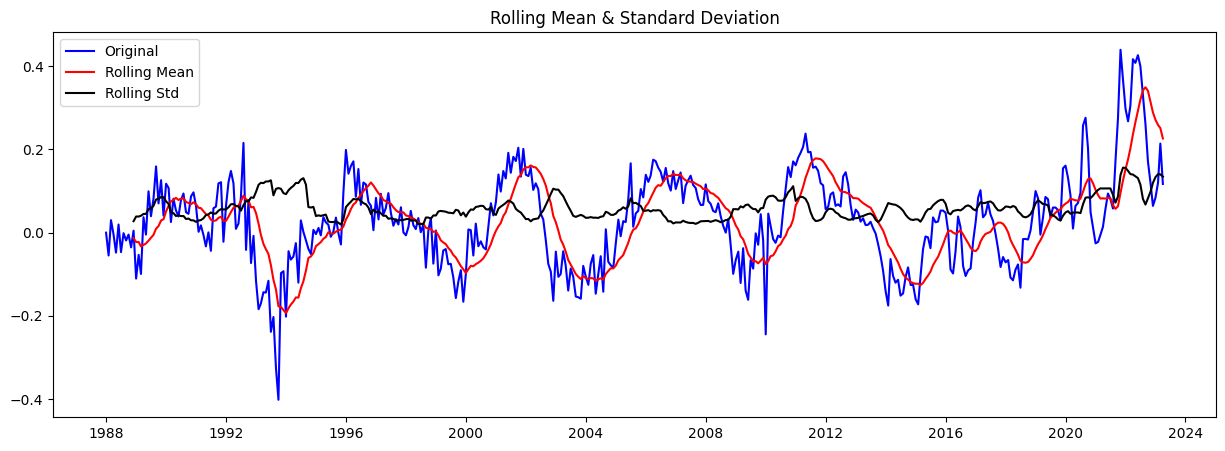

ADF Statistic: -4.539116341774685
p-value: 0.0001669983270733161
Critical Values:
	1%: -3.4462444670071046
	5%: -2.8685466682709975
	10%: -2.5705023309762187


In [21]:
# Exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

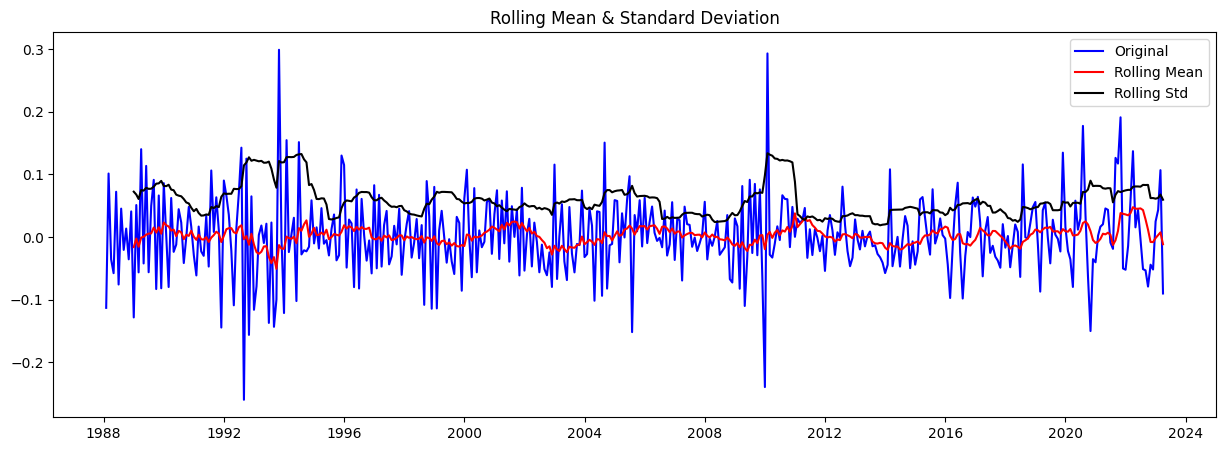

ADF Statistic: -9.89258705841153
p-value: 3.5257143683759986e-17
Critical Values:
	1%: -3.4460914174990296
	5%: -2.868479374038333
	10%: -2.570466459559076


In [22]:
# Time shift
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

**Time Shift performed the best**

# Train/ Test Split

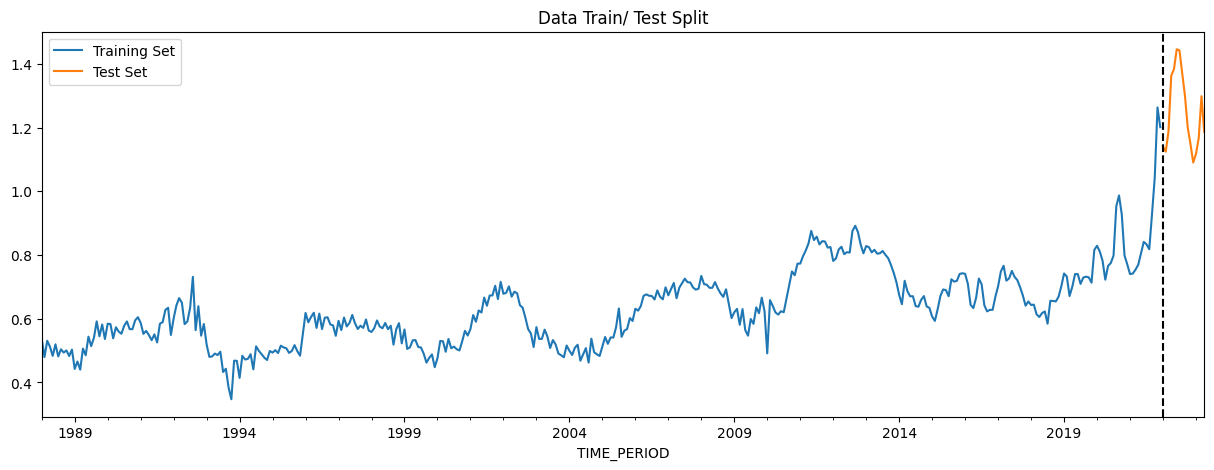

In [205]:
split_time = "2022-01"

data = df.rolling(window=12).mean().dropna()
data = df.copy()
train = data.loc[(data.index >= "1988-01") & (data.index < split_time)]
test = data.loc[data.index >= split_time]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_time, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/ Test Split')
plt.show()

In [195]:
seasonality(data)

12

In [180]:
test_periods = len(test)
forecast_periods = 12 * 10 # 12 months * 10 years (2033)
periods = test_periods + forecast_periods
periods

136

# ARIMA Model

## Auto ARIMA

In [206]:
auto_arima_model = auto_arima(train,
                            start_p=0,
                            d=None,
                            start_q=0,
                            max_p=20,
                            max_d=20,
                            max_q=20,
                            start_P=0,
                            D=None,
                            start_Q=0,
                            max_P=20,
                            max_D=20,
                            max_Q=20,
                            max_order=20,
                            m=12,
                            seasonal=True,
                            stationary=False,
                            information_criterion='aic',
                            alpha=0.05,
                            error_action='trace',
                            trace=False,
                            random_state=None,
                            n_fits=50)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  408
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 751.590
Date:                            Wed, 02 Aug 2023   AIC                          -1497.180
Time:                                    22:42:24   BIC                          -1485.154
Sample:                                01-01-1988   HQIC                         -1492.421
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1881      0.032     -5.800      0.000      -0.252      -0.125
ma.S.L12      -0.0865      0.044     -1.960      0.050      -0.173    1.97e-05
sigma2         0.0015    6.3e-05     23.115      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               452.58
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.65
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [207]:
pred, ci = auto_arima_model.predict(periods, return_conf_int=True)
predictions = pd.DataFrame(pred, columns=["predictions"])
conf_int = pd.DataFrame(ci, columns=["lower_ci", "upper_ci"])
predictions.loc[:,"lower_ci"] = conf_int["lower_ci"].values
predictions.loc[:,"upper_ci"] = conf_int["upper_ci"].values
predictions

,predictions,lower_ci,upper_ci
2022-01-01,1.207489,1.132687,1.282292
2022-02-01,1.207492,1.111138,1.303845
2022-03-01,1.206679,1.092782,1.320576
2022-04-01,1.205767,1.076689,1.334846
2022-05-01,1.202317,1.059664,1.344970
...,...,...,...
2032-12-01,1.167657,0.523144,1.812171
2033-01-01,1.167657,0.520760,1.814554
2033-02-01,1.167657,0.518386,1.816929
2033-03-01,1.167657,0.516020,1.819295


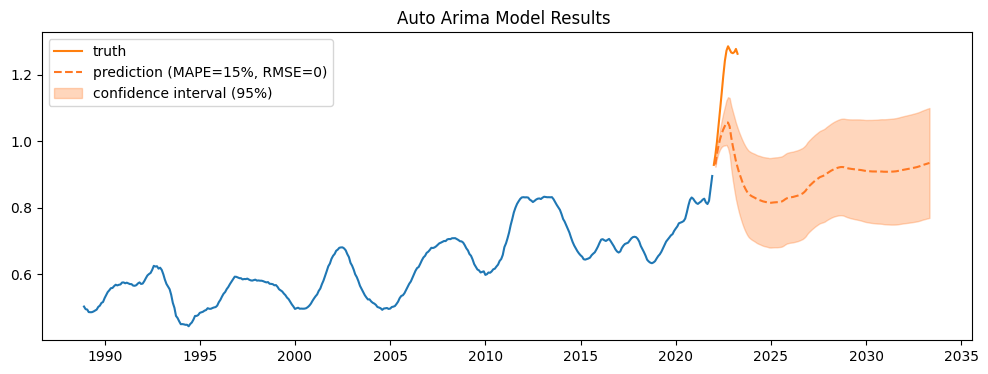

In [203]:

def forecast_results(forecast_df, train_fit = None, title=""):
    start_date = test.index.min()
    end_date = pd.to_datetime('2033-05', format='%Y-%m')

    # Create the new DateTime index until December 2033
    extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

    lower_bounds = forecast_df['lower_ci']
    upper_bounds = forecast_df['upper_ci']
    
    # metrics
    rmse = round(np.sqrt(np.mean(np.square(test.values - predictions.iloc[:test_periods,0].values))))
    mape = round((np.mean(np.abs(test.values - predictions.iloc[:test_periods,0].values)/test.values*100)))
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train.index, train.values)
    
    if train_fit:
        ax.plot(train.index, train_fit.values)
        
    ax.plot(test.index, test.values, label='truth')
    ax.plot(extended_index,  predictions["predictions"].values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={mape}%, RMSE={rmse})")
    ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
    ax.legend()
    ax.set_title(f"{title} Model Results ")
    
forecast_results(predictions, title="Auto Arima")

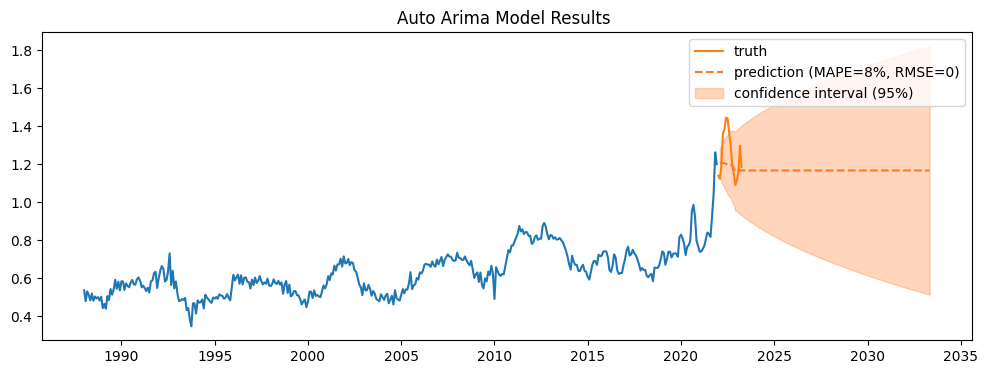

In [208]:

def forecast_results(forecast_df, train_fit = None, title=""):
    start_date = test.index.min()
    end_date = pd.to_datetime('2033-05', format='%Y-%m')

    # Create the new DateTime index until December 2033
    extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

    lower_bounds = forecast_df['lower_ci']
    upper_bounds = forecast_df['upper_ci']
    
    # metrics
    rmse = round(np.sqrt(np.mean(np.square(test.values - predictions.iloc[:test_periods,0].values))))
    mape = round((np.mean(np.abs(test.values - predictions.iloc[:test_periods,0].values)/test.values*100)))
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train.index, train.values)
    
    if train_fit:
        ax.plot(train.index, train_fit.values)
        
    ax.plot(test.index, test.values, label='truth')
    ax.plot(extended_index,  predictions["predictions"].values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={mape}%, RMSE={rmse})")
    ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
    ax.legend()
    ax.set_title(f"{title} Model Results ")
    
forecast_results(predictions, title="Auto Arima")

## ARIMA

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Tuned SARIMA Model Results - Ethanol Price (€/kg)')

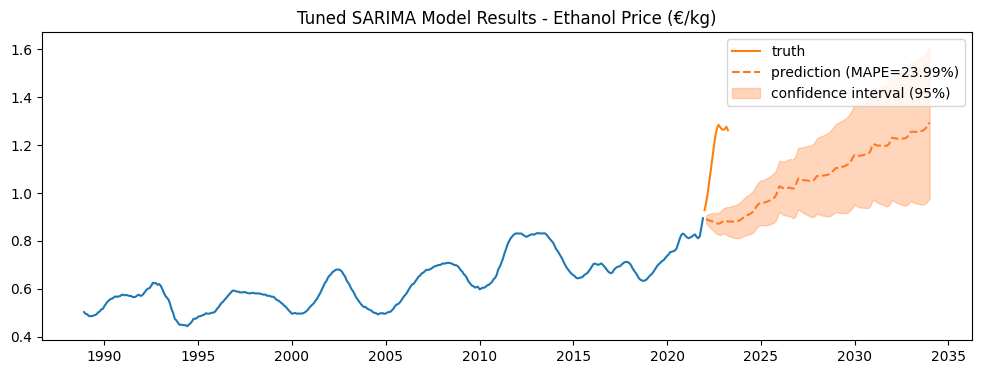

In [204]:
sarima_model = SARIMAX(train, seasonal_order=(5, 0, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

sarima_pred = sarima_fit.get_prediction(test.index.min(), "2033-12")
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']

# metrics
rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
#sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.index, train.values)
#ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("Tuned SARIMA Model Results - Ethanol Price (€/kg)")

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Tuned SARIMA Model Results - Ethanol Price (€/kg)')

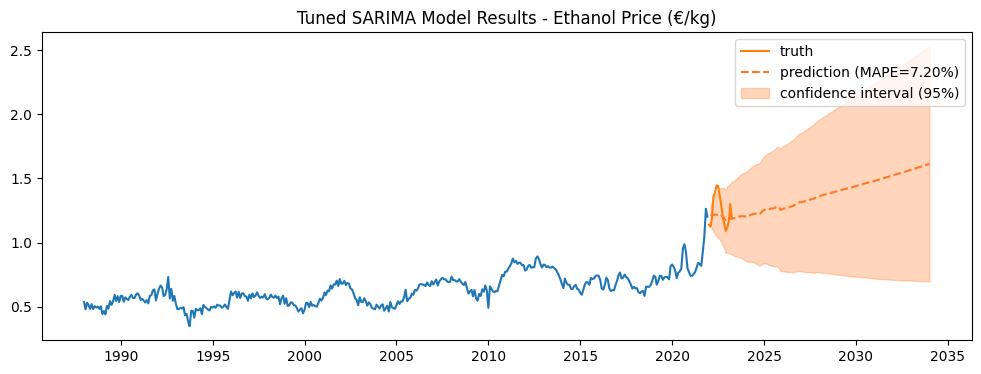

In [209]:
sarima_model = SARIMAX(train, seasonal_order=(5, 0, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

sarima_pred = sarima_fit.get_prediction(test.index.min(), "2033-12")
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']

# metrics
rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values))), 2)
mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values)/test.values*100)), 2)
#sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max()).predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.index, train.values)
#ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("Tuned SARIMA Model Results - Ethanol Price (€/kg)")

In [85]:
test.values

array([1.14019819, 1.12416146, 1.18822008, 1.36260304, 1.38377106,
       1.44581233, 1.44201013, 1.36996149, 1.29883262, 1.20010061,
       1.14822108, 1.09017977, 1.11756439, 1.16700074, 1.29836577,
       1.186485  ])

In [93]:
sarima_fit.get_prediction(test.index.min(), test.index.max()).predicted_mean.values

array([0.8001308 , 0.81090181, 0.80143155, 0.78243224, 0.79947276,
       0.83697137, 0.83307644, 0.82263208, 0.88523379, 0.93520346,
       1.0424905 , 0.99910058, 0.74164732, 0.76048138, 0.75727723,
       0.73951307])

In [212]:
df

TIME_PERIOD
1988-01-01    0.537089
1988-02-01    0.479692
1988-03-01    0.530828
1988-04-01    0.512240
1988-05-01    0.483517
                ...   
2022-12-01    1.090180
2023-01-01    1.117564
2023-02-01    1.167001
2023-03-01    1.298366
2023-04-01    1.186485
Name: OBS_VALUE, Length: 424, dtype: float64

# LSTM

In [216]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)



window_size = 12 
period_test = int(0.2*len(df))

scaler = MinMaxScaler()
X, y = df_to_X_y(scaler.fit_transform(pd.DataFrame(df.rolling(window=24).mean().dropna())), window_size= window_size)

X_train, y_train = X[:-2*period_test], y[:-2*period_test]
X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
X_test, y_test = X[-period_test:], y[-period_test:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
           ,callbacks=[cp]
          )

train_predictions = model.predict(X_train)
train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
val_predictions = model.predict(X_val)
val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
test_predictions = model.predict(X_test)
test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

## Out of Sample Forecast

# Example: Forecasting 100 future time steps
num_forecast_steps = 121

# Create an empty list to store the forecasted values
forecasted_values = []

# Initialize the last known window (X_t) with the last window from the test data
last_known_window = X_test[-1:]

# Perform forecasting for each time step
for i in range(num_forecast_steps):
    # Use the last known window to predict the next time step
    prediction = model.predict(last_known_window)
    
    # Append the forecasted value to the list
    forecasted_values.append(prediction[0, 0])
    
    # Update the last known window (X_t) with the current prediction and shift the window
    last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                            #,"Lower_CI" : lower_bound_values.flatten()[1:]
                            #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                           })

forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))



Epoch 1/50
1/7 [===>..........................] - ETA: 8s - loss: 0.0232 - mean_absolute_percentage_error: 88.9115INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 389ms/step - loss: 0.0215 - mean_absolute_percentage_error: 41286.9062 - val_loss: 0.1042 - val_mean_absolute_percentage_error: 82.7645
Epoch 2/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0194 - mean_absolute_percentage_error: 79.2864INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 337ms/step - loss: 0.0178 - mean_absolute_percentage_error: 69873.4688 - val_loss: 0.0896 - val_mean_absolute_percentage_error: 76.2668
Epoch 3/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0103 - mean_absolute_percentage_error: 626774.7500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 338ms/step - loss: 0.0144 - mean_absolute_percentage_error: 90825.4844 - val_loss: 0.0760 - val_mean_absolute_percentage_error: 69.6669
Epoch 4/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0155 - mean_absolute_percentage_error: 146.9035INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 455ms/step - loss: 0.0115 - mean_absolute_percentage_error: 160987.0469 - val_loss: 0.0632 - val_mean_absolute_percentage_error: 62.9047
Epoch 5/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0096 - mean_absolute_percentage_error: 114.0154INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 363ms/step - loss: 0.0089 - mean_absolute_percentage_error: 172128.2188 - val_loss: 0.0515 - val_mean_absolute_percentage_error: 56.0813
Epoch 6/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0085 - mean_absolute_percentage_error: 1421596.0000INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 338ms/step - loss: 0.0068 - mean_absolute_percentage_error: 205922.1250 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 49.2597
Epoch 7/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0067 - mean_absolute_percentage_error: 74.6331INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 347ms/step - loss: 0.0051 - mean_absolute_percentage_error: 258291.5156 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 42.7591
Epoch 8/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0035 - mean_absolute_percentage_error: 65.4328INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 330ms/step - loss: 0.0039 - mean_absolute_percentage_error: 297754.7812 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 36.7023
Epoch 9/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0028 - mean_absolute_percentage_error: 311.6436INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 341ms/step - loss: 0.0030 - mean_absolute_percentage_error: 339581.6250 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 31.1489
Epoch 10/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - mean_absolute_percentage_error: 2474386.5000INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 347ms/step - loss: 0.0025 - mean_absolute_percentage_error: 358378.0000 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 26.4536
Epoch 11/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0024 - mean_absolute_percentage_error: 68.7935INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 495ms/step - loss: 0.0023 - mean_absolute_percentage_error: 401482.3750 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 22.5951
Epoch 12/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 110.4769INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 353ms/step - loss: 0.0022 - mean_absolute_percentage_error: 413029.7188 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 20.2939
Epoch 13/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0031 - mean_absolute_percentage_error: 334.6378INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 343ms/step - loss: 0.0022 - mean_absolute_percentage_error: 417221.0625 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 18.6322
Epoch 14/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0019 - mean_absolute_percentage_error: 293.2141INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 351ms/step - loss: 0.0021 - mean_absolute_percentage_error: 415932.5000 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 17.9914
Epoch 15/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0019 - mean_absolute_percentage_error: 32.3814INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 360ms/step - loss: 0.0021 - mean_absolute_percentage_error: 414297.3438 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 17.5970
Epoch 16/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0021 - mean_absolute_percentage_error: 408569.0625 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 17.7859
Epoch 17/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0027 - mean_absolute_percentage_error: 2765305.7500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 358ms/step - loss: 0.0020 - mean_absolute_percentage_error: 400506.2812 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 17.4298
Epoch 18/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - mean_absolute_percentage_error: 243.3102INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 363ms/step - loss: 0.0020 - mean_absolute_percentage_error: 389050.0312 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 17.3127
Epoch 19/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - mean_absolute_percentage_error: 2672832.5000INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 334ms/step - loss: 0.0019 - mean_absolute_percentage_error: 387149.8125 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 16.8036
Epoch 20/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0018 - mean_absolute_percentage_error: 2635919.7500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 473ms/step - loss: 0.0019 - mean_absolute_percentage_error: 381797.6562 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 16.0526
Epoch 21/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0018 - mean_absolute_percentage_error: 44.4988INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 347ms/step - loss: 0.0018 - mean_absolute_percentage_error: 377543.4688 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 15.5594
Epoch 22/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0025 - mean_absolute_percentage_error: 75.2486INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 330ms/step - loss: 0.0018 - mean_absolute_percentage_error: 368783.0938 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 15.0111
Epoch 23/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0020 - mean_absolute_percentage_error: 157.4656INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 335ms/step - loss: 0.0018 - mean_absolute_percentage_error: 366745.0625 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 14.4654
Epoch 24/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 305.6901INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 369ms/step - loss: 0.0017 - mean_absolute_percentage_error: 361694.9375 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 14.0431
Epoch 25/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - mean_absolute_percentage_error: 141.9826INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 391ms/step - loss: 0.0017 - mean_absolute_percentage_error: 356051.0312 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 13.3952
Epoch 26/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 72.6393INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 521ms/step - loss: 0.0017 - mean_absolute_percentage_error: 348673.2188 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 13.0251
Epoch 27/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 98.5801INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 591ms/step - loss: 0.0016 - mean_absolute_percentage_error: 344867.5000 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 12.6303
Epoch 28/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 2368132.0000INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 541ms/step - loss: 0.0016 - mean_absolute_percentage_error: 343013.5625 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 12.2617
Epoch 29/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 2332087.0000INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 342ms/step - loss: 0.0016 - mean_absolute_percentage_error: 337789.4062 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 11.9179
Epoch 30/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 68.2762INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 385ms/step - loss: 0.0015 - mean_absolute_percentage_error: 329432.6875 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 11.6878
Epoch 31/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 59.1915INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 374ms/step - loss: 0.0015 - mean_absolute_percentage_error: 325436.9688 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 11.4758
Epoch 32/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0019 - mean_absolute_percentage_error: 2230430.2500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 367ms/step - loss: 0.0015 - mean_absolute_percentage_error: 323041.1562 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 11.2845
Epoch 33/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 53.7312INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 404ms/step - loss: 0.0015 - mean_absolute_percentage_error: 317135.3125 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 11.0710
Epoch 34/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0013 - mean_absolute_percentage_error: 121.6362INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 396ms/step - loss: 0.0014 - mean_absolute_percentage_error: 313000.6562 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 10.9607
Epoch 35/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 92.1138INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 527ms/step - loss: 0.0014 - mean_absolute_percentage_error: 303507.9688 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 10.8529
Epoch 36/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - mean_absolute_percentage_error: 128.7600INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 358ms/step - loss: 0.0014 - mean_absolute_percentage_error: 300264.7812 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 10.7484
Epoch 37/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - mean_absolute_percentage_error: 63.4691INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 370ms/step - loss: 0.0014 - mean_absolute_percentage_error: 296595.9062 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 10.6511
Epoch 38/50
1/7 [===>..........................] - ETA: 0s - loss: 9.9011e-04 - mean_absolute_percentage_error: 19.8343INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 354ms/step - loss: 0.0013 - mean_absolute_percentage_error: 292842.1875 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 10.5749
Epoch 39/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - mean_absolute_percentage_error: 52.0726INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 371ms/step - loss: 0.0013 - mean_absolute_percentage_error: 288245.1250 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 10.5276
Epoch 40/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0013 - mean_absolute_percentage_error: 46.8737INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 362ms/step - loss: 0.0013 - mean_absolute_percentage_error: 283311.6875 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 10.4922
Epoch 41/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0012 - mean_absolute_percentage_error: 91.5391INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 366ms/step - loss: 0.0013 - mean_absolute_percentage_error: 279588.5000 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 10.4575
Epoch 42/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 50.9841INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 389ms/step - loss: 0.0013 - mean_absolute_percentage_error: 272960.8438 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 10.4512
Epoch 43/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 175.9341INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 563ms/step - loss: 0.0013 - mean_absolute_percentage_error: 267933.7500 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 10.4466
Epoch 44/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 140.1384INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 373ms/step - loss: 0.0013 - mean_absolute_percentage_error: 266088.4688 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 10.5010
Epoch 45/50
1/7 [===>..........................] - ETA: 0s - loss: 9.5895e-04 - mean_absolute_percentage_error: 118.2846INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 357ms/step - loss: 0.0012 - mean_absolute_percentage_error: 263620.7500 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.5610
Epoch 46/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0012 - mean_absolute_percentage_error: 163.7037INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 348ms/step - loss: 0.0012 - mean_absolute_percentage_error: 259759.7969 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.5335
Epoch 47/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0011 - mean_absolute_percentage_error: 20.0640INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 382ms/step - loss: 0.0012 - mean_absolute_percentage_error: 255396.9375 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.5661
Epoch 48/50
1/7 [===>..........................] - ETA: 0s - loss: 9.7937e-04 - mean_absolute_percentage_error: 25.3869INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 394ms/step - loss: 0.0012 - mean_absolute_percentage_error: 252750.4844 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 10.6612
Epoch 49/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - mean_absolute_percentage_error: 1735903.7500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 2s 368ms/step - loss: 0.0012 - mean_absolute_percentage_error: 251429.1094 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 10.6760
Epoch 50/50
1/7 [===>..........................] - ETA: 0s - loss: 0.0014 - mean_absolute_percentage_error: 22.3332INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1/1 [==============================] - 0s 21ms/step


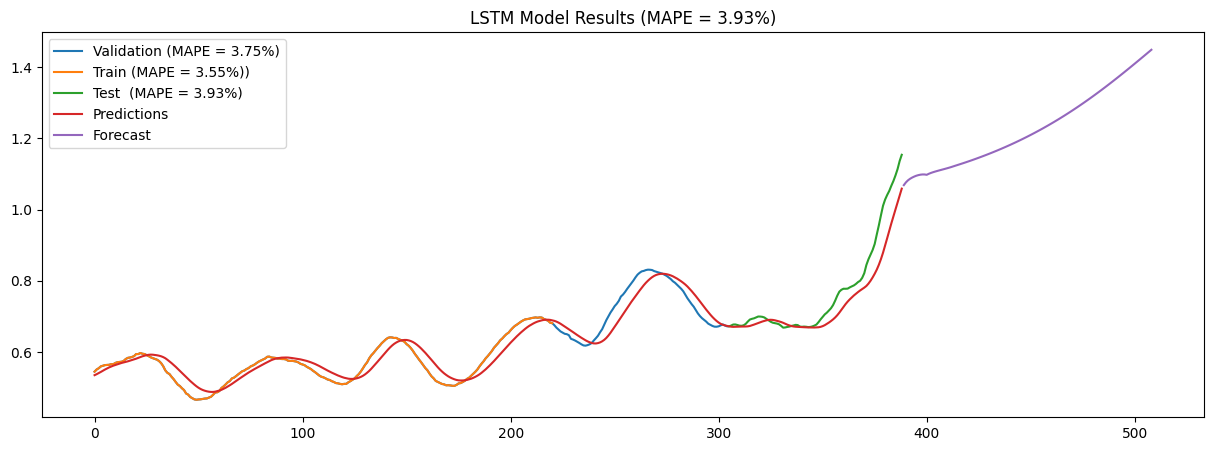

In [217]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

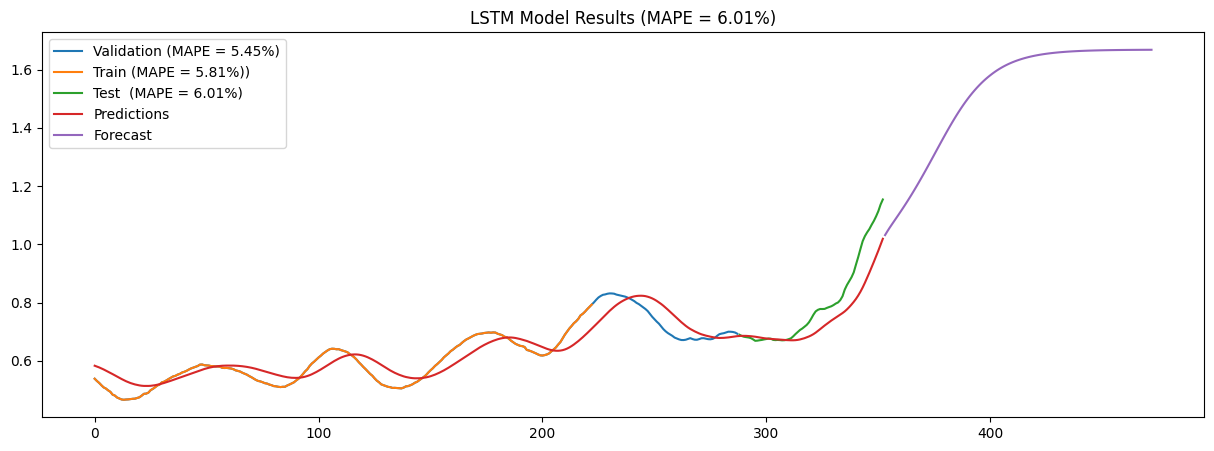

In [215]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

# Volatility Forecasting - Heteroescedascity

If there is non-constant variance (i.e. the timeseries residuals do not follow a uniform distirbution), we can try to forecast the variance, and use it as input for a SARIMAX model

In [133]:
from arch import arch_model

model = arch_model(np.log(df), vol="GARCH", p=1, q=1)
results = model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 154789648455755.88
Iteration:      2,   Func. Count:     15,   Neg. LLF: 207530528.9231392
Iteration:      3,   Func. Count:     22,   Neg. LLF: 21.360077420077687
Iteration:      4,   Func. Count:     28,   Neg. LLF: 39.602058959462454
Iteration:      5,   Func. Count:     34,   Neg. LLF: -207.73197552098495
Iteration:      6,   Func. Count:     39,   Neg. LLF: -206.14167708735405
Iteration:      7,   Func. Count:     45,   Neg. LLF: 615087.6610569904
Iteration:      8,   Func. Count:     51,   Neg. LLF: -200.07176271679623
Iteration:      9,   Func. Count:     57,   Neg. LLF: -208.2248616929781
Iteration:     10,   Func. Count:     63,   Neg. LLF: -128.425470377427
Iteration:     11,   Func. Count:     69,   Neg. LLF: -211.42944727032094
Iteration:     12,   Func. Count:     74,   Neg. LLF: -211.43725468277802
Iteration:     13,   Func. Count:     79,   Neg. LLF: -211.44409738242211
Iteration:     14,   Func. Count:     84,   Neg.

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [134]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              OBS_VALUE   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                211.454
Distribution:                  Normal   AIC:                          -414.909
Method:            Maximum Likelihood   BIC:                          -398.710
                                        No. Observations:                  424
Date:                Tue, Aug 01 2023   Df Residuals:                      423
Time:                        23:14:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.5142  1.799e-02    -28.587 9.775e-180 [ -0.549, -0.479]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8696e-03  5.850e-04      3.196  1.393e-03 [7.231e-04,3.016e-03]
alpha[1]       0.7577  8.983e-02      8.435  3.316e-17     [  0.582,  0.934]
beta[1]        0.2129  9.143e-02      2.328  1.989e-02   [3.369e-02,  0.392]
============================================================================

Covariance estimator: robust
"""

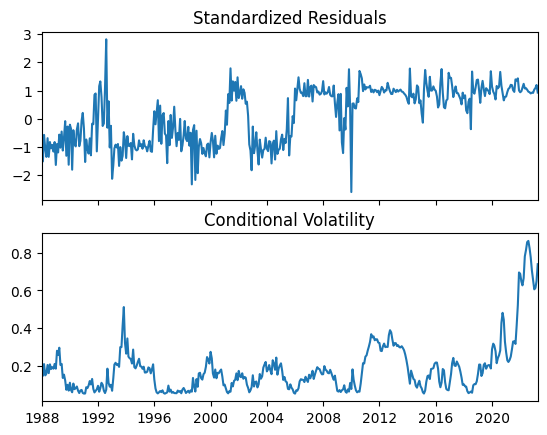

In [135]:
fig = results.plot()
plt.show()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 45223756269.97154
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17346.873536538405
Iteration:      3,   Func. Count:     27,   Neg. LLF: 16840979374.062656
Iteration:      4,   Func. Count:     38,   Neg. LLF: 303217885.41762805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -862.1822027955329
            Iterations: 5
            Function evaluations: 47
            Gradient evaluations: 4


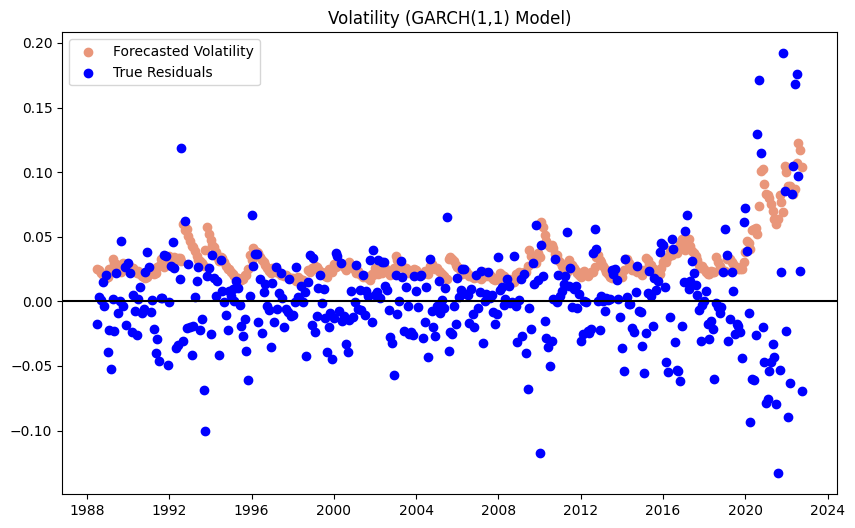

In [162]:
model = arch_model(seasonal_decompose(df).resid.dropna(), vol="GARCH", p=1, q=1)
results = model.fit()
volatility = results._volatility
volatility = volatility
residuals = seasonal_decompose(df).resid.dropna()
# Plot the volatility
plt.figure(figsize=(10, 6))
plt.scatter(seasonal_decompose(df).resid.dropna().index, volatility, label='Forecasted Volatility', color='darksalmon')
plt.axhline(0, color='black', linestyle='-') # Adding a horizontal line at y=0
plt.scatter(seasonal_decompose(df).resid.dropna().index, residuals, label='True Residuals', color = "blue")
plt.title('Volatility (GARCH(1,1) Model)')
plt.legend()
plt.show()

In [143]:
np.sqrt(results.forecast(horizon = forecast_periods).variance).iloc[-1,:].to_list()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


[0.09705939532068286,
 0.09622666982240526,
 0.09540354697015604,
 0.09458993714380472,
 0.09378575156462028,
 0.09299090228402268,
 0.09220530217241527,
 0.09142886490809858,
 0.09066150496626613,
 0.08990313760808279,
 0.08915367886984646,
 0.0884130455522338,
 0.08768115520963088,
 0.08695792613954977,
 0.08624327737213192,
 0.08553712865973946,
 0.08483940046663573,
 0.08415001395875597,
 0.0834688909935697,
 0.08279595411003605,
 0.08213112651865354,
 0.0814743320916056,
 0.08082549535300379,
 0.08018454146922988,
 0.07955139623937882,
 0.0789259860858041,
 0.07830823804476757,
 0.0776980797571952,
 0.077095439459541,
 0.07650024597476092,
 0.07591242870339858,
 0.0753319176147851,
 0.07475864323835484,
 0.07419253665507934,
 0.07363352948902138,
 0.07308155389901132,
 0.07253654257044805,
 0.07199842870722635,
 0.07146714602379323,
 0.07094262873733496,
 0.07042481156009729,
 0.06991362969184076,
 0.06940901881243342,
 0.06891091507458279,
 0.06841925509670933,
 0.067933975955963

In [147]:
list(volatility) + np.sqrt(results.forecast(horizon = forecast_periods).variance).iloc[-1,:].to_list()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


[0.024819887676480395,
 0.024040947721132865,
 0.021896561075089714,
 0.020035961793758026,
 0.019535100727991476,
 0.018141040237098387,
 0.018970845682758024,
 0.02518332802676474,
 0.02498839646797898,
 0.032774628206392126,
 0.029422223862192086,
 0.02852500206408869,
 0.027425324335483177,
 0.025176276194799417,
 0.022844381453554143,
 0.029292049977045896,
 0.02647482373391358,
 0.02651846682925819,
 0.025447436915201353,
 0.026521982182976554,
 0.02573617591327363,
 0.025718716548809587,
 0.023393649947053063,
 0.02165013265332418,
 0.023144449067953068,
 0.021109269660248453,
 0.019899575915136965,
 0.01886130886637015,
 0.017723479327204594,
 0.019178927643073176,
 0.02444783214057336,
 0.0250118805065824,
 0.02308124606807989,
 0.02104766982671937,
 0.021684803754975935,
 0.026864157726190947,
 0.0276657941896001,
 0.03274728059434895,
 0.029400823005821662,
 0.026504018260174195,
 0.028744760030103806,
 0.030117391900197212,
 0.035129420918465715,
 0.03147017594737354,
 0.03

In [163]:
len(volatility)

412

In [158]:
train.shape

(408,)

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Tuned SARIMA Model Results - Ethanol Price (€/kg)')

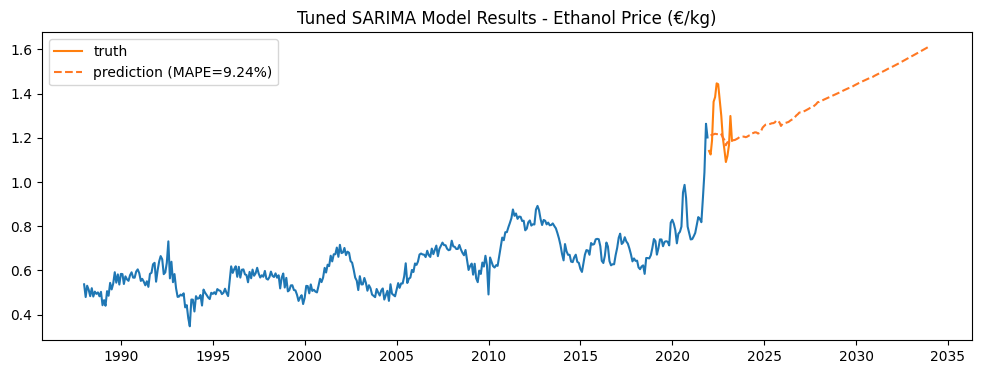

In [168]:
sarima_model = SARIMAX(train,list(volatility[:408]), seasonal_order=(5, 0, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

"""
sarima_pred = sarima_fit.get_prediction(test.index.min(), "2033-12"))
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']
"""
# metrics
rmse = round(np.sqrt(np.mean(np.square(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values))), 2)
mape = round((np.mean(np.abs(test.values - sarima_fit.get_prediction(test.index.min(), test.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values)/test.values*100)), 2)
sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction(df.index.min(), df.index.max(), exog=list(volatility[len(volatility)-len(test):])).predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.index, train.values)
#ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(mape))
#ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("Tuned SARIMA Model Results - Ethanol Price (€/kg)")

In [695]:
results._volatility[-1]

37381.88780833805

In [685]:
dec.resid.dropna().tail()

TIME_PERIOD
2022-06-01   -13893.532969
2022-07-01     7696.307893
2022-08-01     7676.460274
2022-09-01     2426.488845
2022-10-01    41931.880512
Name: resid, dtype: float64

# Exponential Smoothing

## Setup Hyperparameter Tuning

In [334]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
    # fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    # make forecast
    yhat = model_fit.forecast(test_periods)
    return yhat


# root mean squared error
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(train, test, cfg):
    
    """ 
    predictions = list()
    # seed history with training dataset
    history = train
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        pd.concat([history, test.iloc[i,:]])
    """
    prediction = exp_smoothing_forecast(train, cfg)
    # estimate prediction error
    error = (np.mean(np.square(test.values - prediction.values)))
    return error
 
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, test, cfg)
    else:
    # one failure during model validation suggests an unstable config
        try: 
            result = walk_forward_validation(train, test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(train, test, cfg_list, parallel=True, debug = False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, test, cfg, debug) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [348]:

 
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
    result = None
    rmse = None
    mape = None
    aic = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
            t,d,s,p,b,r = cfg
            # define model model
            model = ExponentialSmoothing(train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
            # fit model
            model_fit = model.fit(optimized=True, remove_bias=r)
            # make forecast
            pred = model_fit.forecast(test_periods)
            # Calculate metrics
            rmse = np.sqrt(np.mean(np.square(test.values - pred.values)))
            mape = (np.mean(np.abs(test.values -  pred.values)/test.values*100))
            aic = model_fit.aic
    else:
    # one failure during model validation suggests an unstable config
        try: 
            t,d,s,p,b,r = cfg
            # define model model
            model = ExponentialSmoothing(train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
            # fit model
            model_fit = model.fit(optimized=True, remove_bias=r)
            # make forecast
            pred = model_fit.forecast(test_periods)
            # Calculate metrics
            rmse = np.sqrt(np.mean(np.square(test.values - pred.values)))
            mape = (np.mean(np.abs(test.values - pred.values)/test.values*100))
            aic = model_fit.aic
        except:
            error = None
    return (key, rmse, mape, aic)
 
# grid search configs
def grid_search(train, test, cfg_list, parallel=True, debug = False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, test, cfg, debug) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[seasonality(df)]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models





In [355]:
warnings.filterwarnings("ignore")
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(train, test, cfg_list, parallel=False, debug = False)
print('done')
# list top 3 configs
for cfg, rmse, mape, aic in scores[:3]:
    print(cfg,  rmse, mape, aic)

done
[None, False, None, 12, False, False] 67489.09763457967 17.402143151811206 7781.390663655013
[None, False, None, 12, True, True] 67493.9220197003 17.53183828563924 7793.173165112848
[None, False, None, 12, False, True] 67494.79284752392 17.533399475452647 7781.390663655013


C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Sesonal Exponential Smoothing Model w/ Growth Results ')

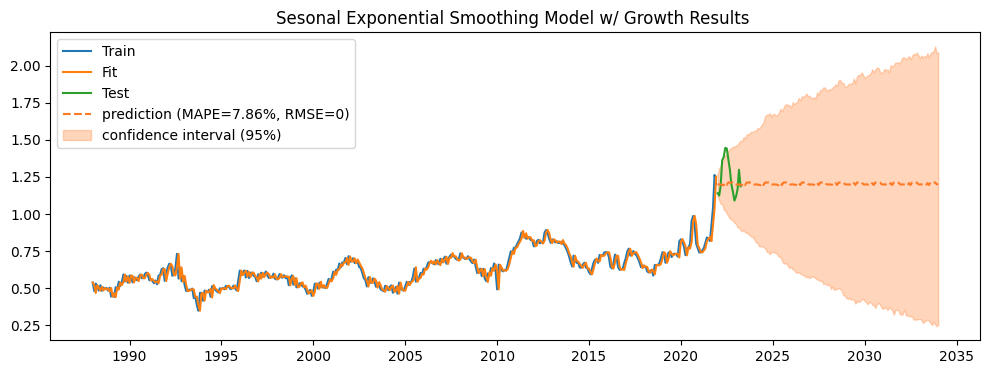

In [119]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

train_x = train[train.index >= pd.to_datetime("1988")].copy()

# Build model.
ets_model = ETSModel(
    endog=train_x, # should be a pd.Series
    trend="mul",
    damped_trend=True,
    seasonal="mul",
    seasonal_periods=12
)
fit = ets_model.fit()


start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

pred = fit.get_prediction(start=test.index[0], end=extended_index[-1]).summary_frame(alpha=0.05)
pred = pred.rename(columns={"mean":"prediction"})


test_pred = fit.get_prediction(start=test.index[0], end=test.index[-1]).summary_frame(alpha=0.05)
test_pred = test_pred.rename(columns={"mean":"prediction"})
# Calculate metrics
rmse = np.sqrt(np.mean(np.square(test.values - test_pred.prediction.values)))
mape = (np.mean(np.abs(test.values -  test_pred.prediction.values)/test.values*100))
aic = fit.aic


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_x.index, train_x.values, label = "Train")
ax.plot(train_x.index, fit.fittedvalues, label = "Fit")

ax.plot(test.index, test.values, label='Test')
ax.plot(pred.index,  pred.prediction.values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={round(mape,2)}%, RMSE={round(rmse)})")
ax.fill_between(pred.index, pred.pi_lower.values, pred.pi_upper.values, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title(f"Sesonal Exponential Smoothing Model w/ Growth Results ")

Text(0.5, 1.0, 'Cross Validation Exponential Smoothing Model Results ')

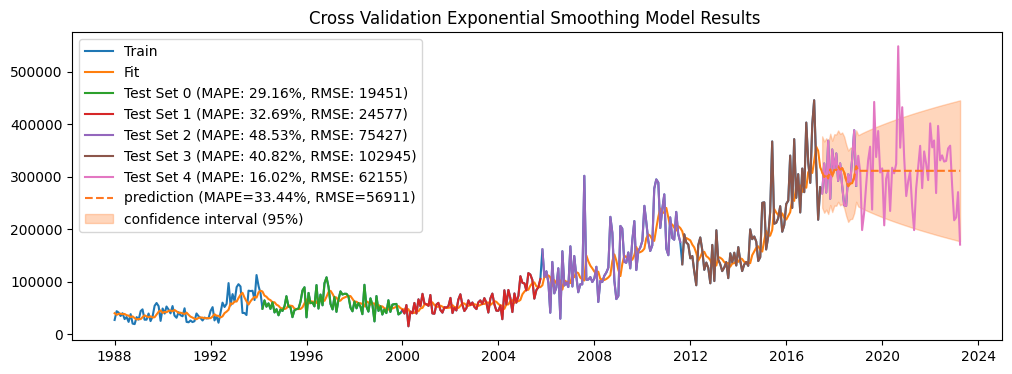

In [466]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 5)
rmses = []
mapes = []
aics = []
test_sets = []
train_sets = []
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    train_sets.append(cv_train)
    test_sets.append(cv_test)
    # Build model.
    ets_model = ETSModel(
        endog=train.OBS_VALUE, # should be a pd.Series
        #trend="add",
        #damped_trend=True,
        #seasonal="mul",
        #seasonal_periods=12
    )
    fit = ets_model.fit()
    pred = fit.get_prediction(start = cv_test.index.values[0], end = cv_test.index.values[-1]).summary_frame(alpha=0.05)
    pred = pred.rename(columns={"mean":"prediction"})
    true_values = cv_test.values

    # Calculate metrics
    rmse = np.sqrt(np.mean(np.square(cv_test.values - pred.prediction.values)))
    mape = (np.mean(np.abs(cv_test.values -  pred.prediction.values)/cv_test.values*100))
    aic = fit.aic
    rmses.append(rmse)
    mapes.append(mape)
    aics.append(aic)

rmse = np.mean(rmses)
mape = np.mean(mapes)
aic = np.mean(aics)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values, label = "Train")
ax.plot(train.OBS_VALUE.index, fit.fittedvalues, label = "Fit")
for i in range(len(test_sets)):
    ax.plot(test_sets[i].index, test_sets[i].values, label=f'Test Set {i} (MAPE: {round(mapes[i],2)}%, RMSE: {round(rmses[i])})')
ax.plot(pred.index,  pred.prediction.values, color='#ff7823', linestyle='--', label=f"prediction (MAPE={round(mape,2)}%, RMSE={round(rmse)})")
ax.fill_between(pred.index, pred.pi_lower.values, pred.pi_upper.values, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title(f"Cross Validation Exponential Smoothing Model Results ")

In [465]:
train_sets[4]

,OBS_VALUE
TIME_PERIOD,
1988-01-01,27411
1988-02-01,44108
1988-03-01,41559
1988-04-01,34977
1988-05-01,40197
...,...
2017-02-01,401068
2017-03-01,445912
2017-04-01,324036


In [455]:
mapes

[30.254356293412773,
 33.81075449411049,
 49.754094726822416,
 42.441259460804865,
 16.505564727706183]

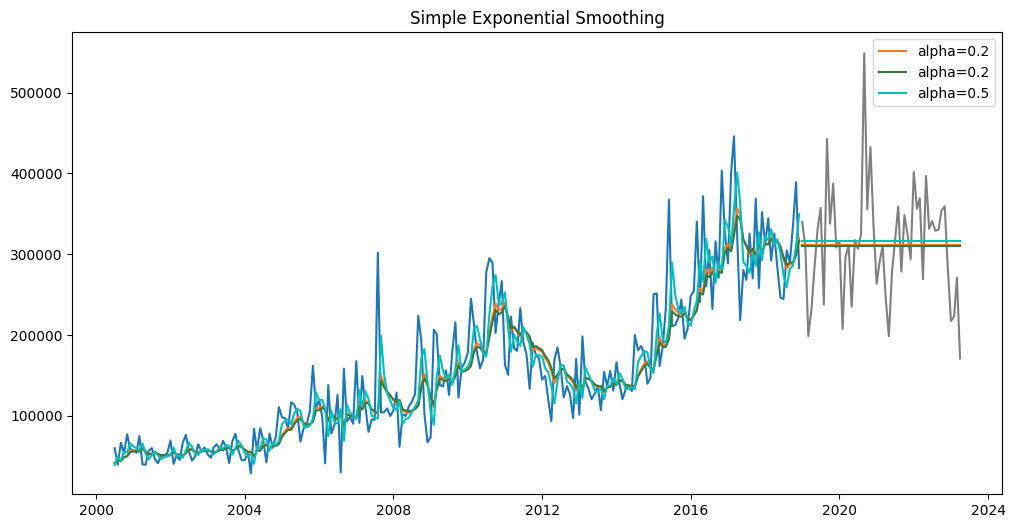

In [389]:
train.index = pd.to_datetime(train.index)
model = SimpleExpSmoothing(np.asarray(train['OBS_VALUE']), )

fit1 = model.fit()
pred1 = fit1.forecast(test_periods)
fit2 = model.fit(smoothing_level=.2, optimized=False)
pred2 = fit2.forecast(test_periods)
fit3 = model.fit(smoothing_level=.5, optimized=False)
pred3 = fit3.forecast(test_periods)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend()
    

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


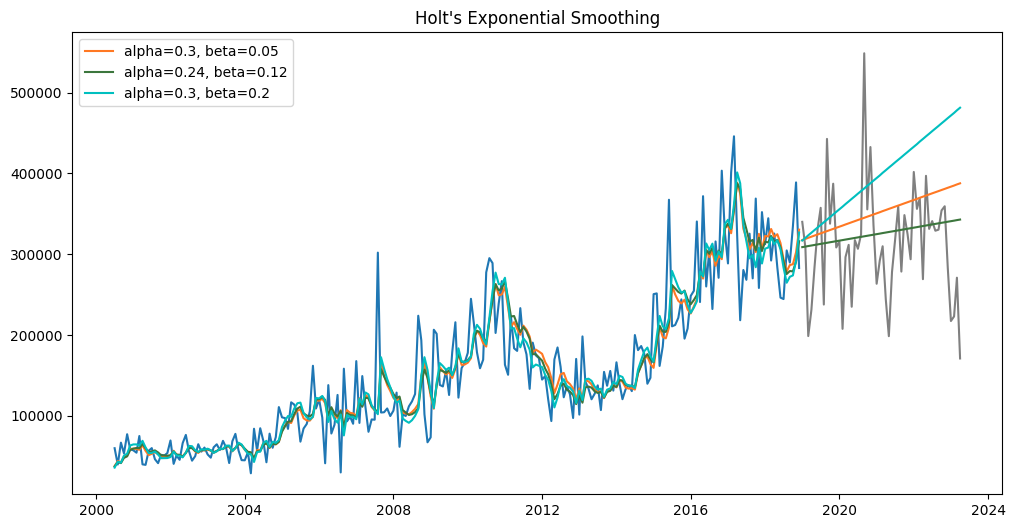

In [37]:
train.index = pd.to_datetime(train.index)
model = Holt(np.asarray(train['OBS_VALUE']))

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05, optimized=False)
pred1 = fit1.forecast(test_periods)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(test_periods)
fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2, optimized=False)
pred3 = fit3.forecast(test_periods)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()

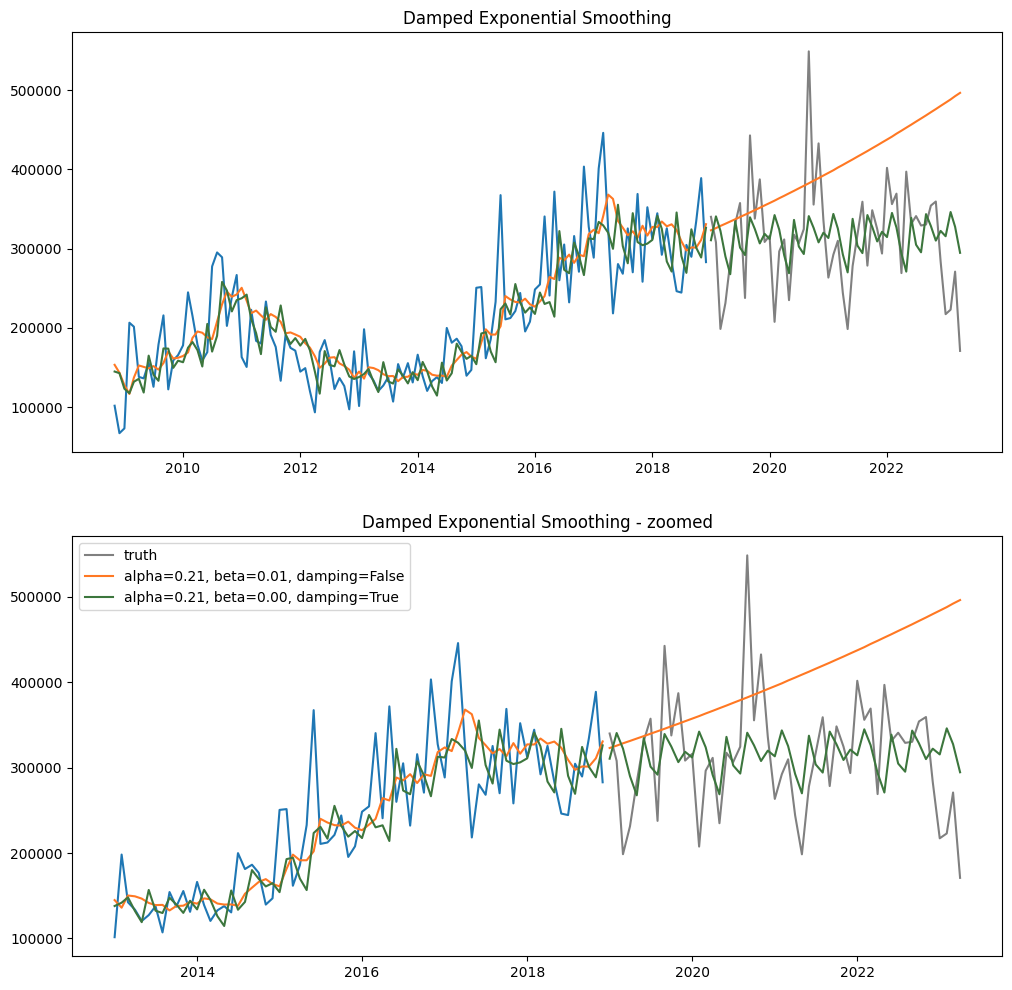

In [442]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(np.asarray(train['OBS_VALUE']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['OBS_VALUE']), trend='mul', seasonal="mul", seasonal_periods=12, damped_trend=True)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(test_periods)
pred2 = fit2.forecast(test_periods)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[250:], train.values[250:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[300:], train.values[300:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[250:], f.fittedvalues[250:], color=c)
    ax[1].plot(train.index[300:], f.fittedvalues[300:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


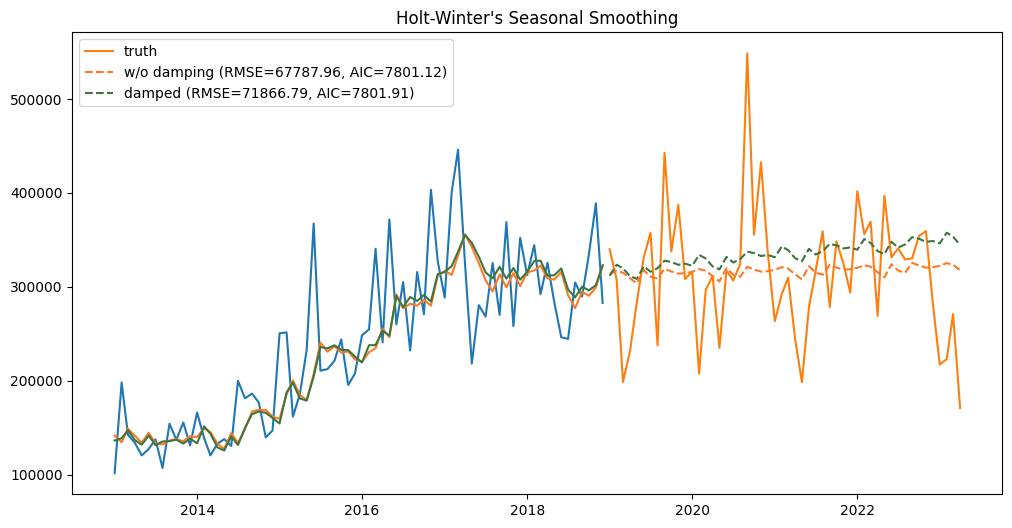

In [65]:
c

# ARIMA model

In [135]:


sarima_model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(1, 1, 3, 12), enforce_invertibility=False, enforce_stationarity=False)
#sarima_model = ARIMA(train, order=(1, 1, 3))
sarima_fit = sarima_model.fit()


C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


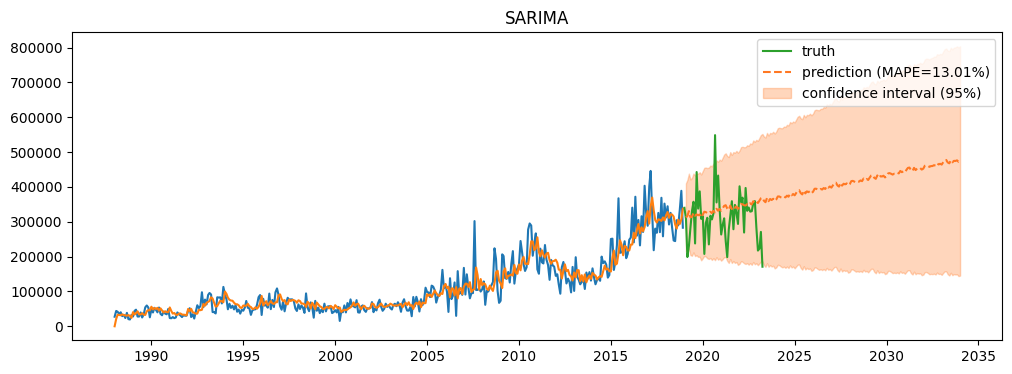

In [138]:

start_date = test.index.min()
end_date = pd.to_datetime('2034-01', format='%Y-%m')

# Create the new DateTime index until December 2033
extended_index = pd.date_range(start=start_date, end=end_date, freq='M')

sarima_pred = sarima_fit.get_prediction("2019-01", "2033-12")
predicted_means = sarima_pred.predicted_mean
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower OBS_VALUE']
upper_bounds = predicted_intervals['upper OBS_VALUE']

sarima_rmse = np.sqrt(np.mean(np.abs(df.values - sarima_fit.get_prediction("1998-01", "2023-04").predicted_mean.values)/df.values*100))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values)
ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean)
ax.plot(test.index, test.values, label='truth')
ax.plot(extended_index, predicted_means, color='#ff7823', linestyle='--', label="prediction (MAPE={:0.2f}%)".format(sarima_rmse))
ax.fill_between(extended_index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("SARIMA")

In [125]:
extended_index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31',
               ...
               '2033-02-28', '2033-03-31', '2033-04-30', '2033-05-31',
               '2033-06-30', '2033-07-31', '2033-08-31', '2033-09-30',
               '2033-10-31', '2033-11-30'],
              dtype='datetime64[ns]', length=179, freq='M')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.OBS_VALUE.index, train.OBS_VALUE.values);
ax.plot(train.OBS_VALUE.index, sarima_fit.get_prediction("1988-01", "2018-12").predicted_mean);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

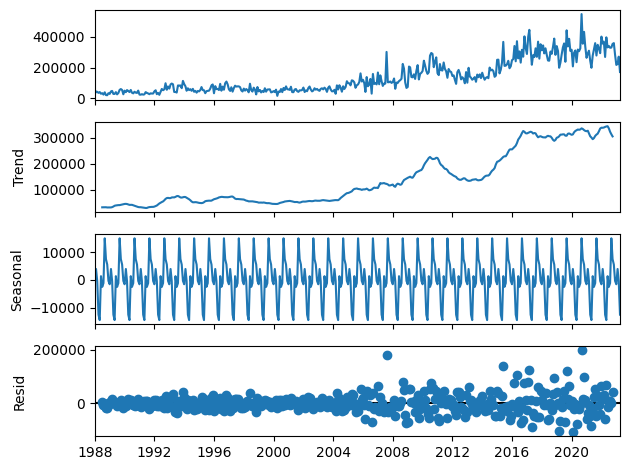

In [147]:
seasonal_decompose(df).plot()
plt.show()

In [13]:
# Draw ACF and PACF plots

sm.graphics.tsa.plot_acf(df_log_shift['OBS_VALUE'], lags = 15) # Select AR order
sm.graphics.tsa.plot_pacf(df_log_shift['OBS_VALUE'], lags = 15) # Select MA order
plt.xticks()
plt.show()

NameError: name 'df_log_shift' is not defined

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 30),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(df_log_shift['OBS_VALUE'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'d': 0, 'p': 24, 'q': 29, 'trend': 'n'}
best loss: 0.07469131130693471


In [26]:
def plot_arima(data_values, order = (1,1,1), trend = 'c'):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend = trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label = "original Series", linewidth = 4)
    plt.plot(results.fittedvalues, color='red', label = "Predictions", linestyle='dashed', linewidth = 3)
    plt.legend(fontsize = 25)
    plt.xlabel('Months', fontsize = 25)
    plt.ylabel('Count', fontsize = 25)
    plt.show()

print(results['best_params'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(data_values, order=order, trend = results['best_params']['trend'])

TypeError: 'ARIMAResultsWrapper' object is not subscriptable

2023-05-01    255768.160520
2023-06-01    255596.414568
2023-07-01    268292.209685
2023-08-01    268292.209685
2023-09-01    268292.209685
                  ...      
2035-06-01    268292.209685
2035-07-01    268292.209685
2035-08-01    268292.209685
2035-09-01    268292.209685
2035-10-01    268292.209685
Freq: MS, Name: predicted_mean, Length: 150, dtype: float64

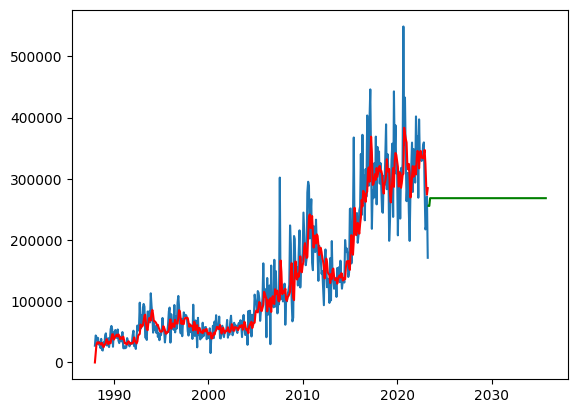

In [49]:
model = ARIMA(df, order=(0,1,3)) 
results = model.fit()
plt.plot(df)
plt.plot(results.fittedvalues, color='red')

forecast = results.forecast(150)
forecast
plt.plot(forecast, color='green')


Text(0.5, 1.0, 'ARIMA Results vs. Real Volume')

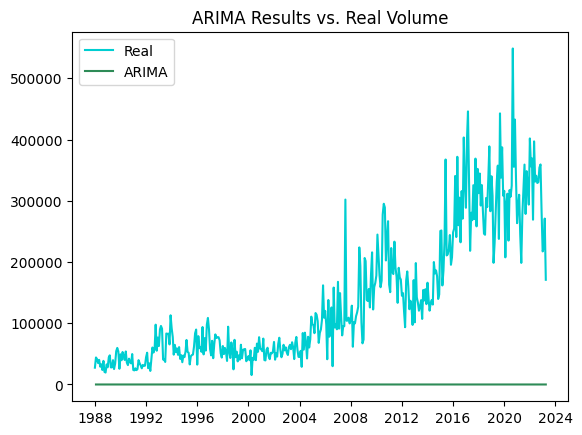

In [44]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, label = "Real", color = "darkturquoise")
plt.plot(results.fittedvalues, label = "ARIMA", color = "seagreen")
plt.legend(loc='best')
plt.title('ARIMA Results vs. Real Volume')

* mean average percentage errror
* LSTM

<Axes: >

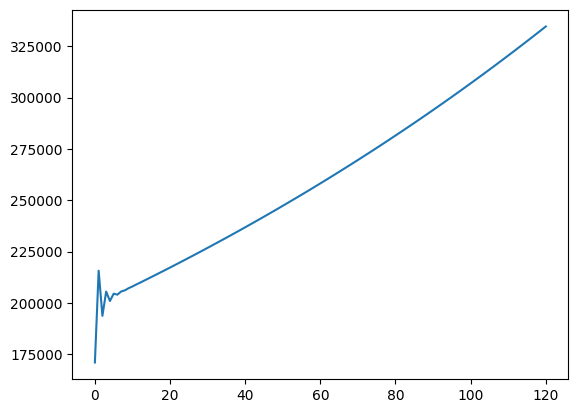

In [210]:
# Number of steps to forecast
n_steps = 120

# Forecast
forecast = results.forecast(steps=n_steps)

# Reverse the differencing
forecast_reversed = np.r_[df_log.iloc[-1], forecast].cumsum()

# Reverse the log transformation
forecast_reversed = np.exp(forecast_reversed)
pd.Series(forecast_reversed).plot()

In [217]:
#df = df.drop('forcast_SARIMA_1', axis = 1)
df.tail()

,OBS_VALUE
TIME_PERIOD,
2022-12-01,283449.36
2023-01-01,217277.89
2023-02-01,222961.62
2023-03-01,270905.33
2023-04-01,170948.46


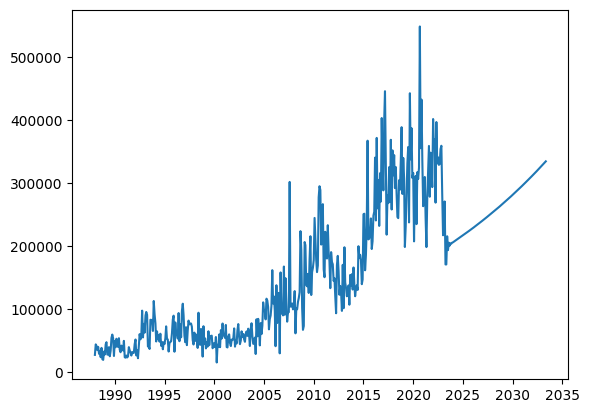

In [225]:
start = datetime.datetime.strptime("2023-05-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,121)]
future = pd.DataFrame(forecast_reversed, index=date_list, columns= df.columns)
future_prediction = pd.concat([df, future])
plt.plot(future_prediction)

In [33]:
stepwise_model = auto_arima(df, start_p=0, start_q=0,
                           max_p=0, max_q=3, m=12,
                           start_P=0, seasonal=True, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=10336.301, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10338.682, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=10336.921, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10184.155, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10336.704, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=10182.689, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=10184.262, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=10185.752, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=10182.864, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=10181.458, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=10182.897, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=10182.866, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=10184.765, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=10180.645, Time=0.06 sec
 ARIM

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

Text(0.5, 1.0, 'ARIMA Results vs. Real Volume')

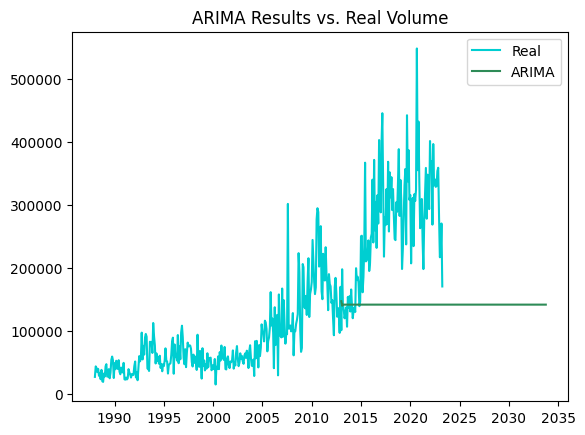

In [41]:
results = stepwise_model.fit_predict(df[:300], n_periods = 250)


plt.plot(df, label = "Real", color = "darkturquoise")
plt.plot(results, label = "ARIMA", color = "seagreen")
plt.legend(loc='best')
plt.title('ARIMA Results vs. Real Volume')




In [179]:
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.2187
1988-02-01    10.2187
1988-03-01    10.2187
1988-04-01    10.2187
1988-05-01    10.2187
               ...   
2022-12-01    10.2187
2023-01-01    10.2187
2023-02-01    10.2187
2023-03-01    10.2187
2023-04-01    10.2187
Length: 424, dtype: float64

In [180]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.218700
1988-02-01    10.218700
1988-03-01    10.694396
1988-04-01    11.033782
1988-05-01    11.209997
                ...    
2022-12-01    13.267439
2023-01-01    13.391848
2023-02-01    13.529402
2023-03-01    13.523579
2023-04-01    13.435341
Length: 424, dtype: float64

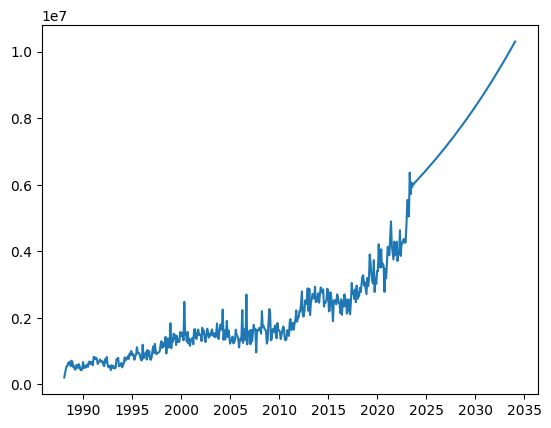

In [186]:
plt.plot(np.exp(pd.Series(results.predict(start=0, end=552)).cumsum() + predictions_ARIMA_log.mean()))

In [176]:
predictions_ARIMA_diff
np.exp(predictions_ARIMA_diff_cumsum)


TIME_PERIOD
1988-02-01     1.000000
1988-03-01     1.609135
1988-04-01     2.259363
1988-05-01     2.694729
1988-06-01     2.727975
                ...    
2022-12-01    21.088743
2023-01-01    23.882568
2023-02-01    27.404356
2023-03-01    27.245266
2023-04-01    24.944202
Length: 423, dtype: float64

In [204]:
model = sm.tsa.statespace.SARIMAX(df.dropna()['OBS_VALUE'],order=(2,1,2),seasonal_order=(2,1,2,6))
result=model.fit()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: Schur decomposition solver error.

<Axes: xlabel='TIME_PERIOD'>

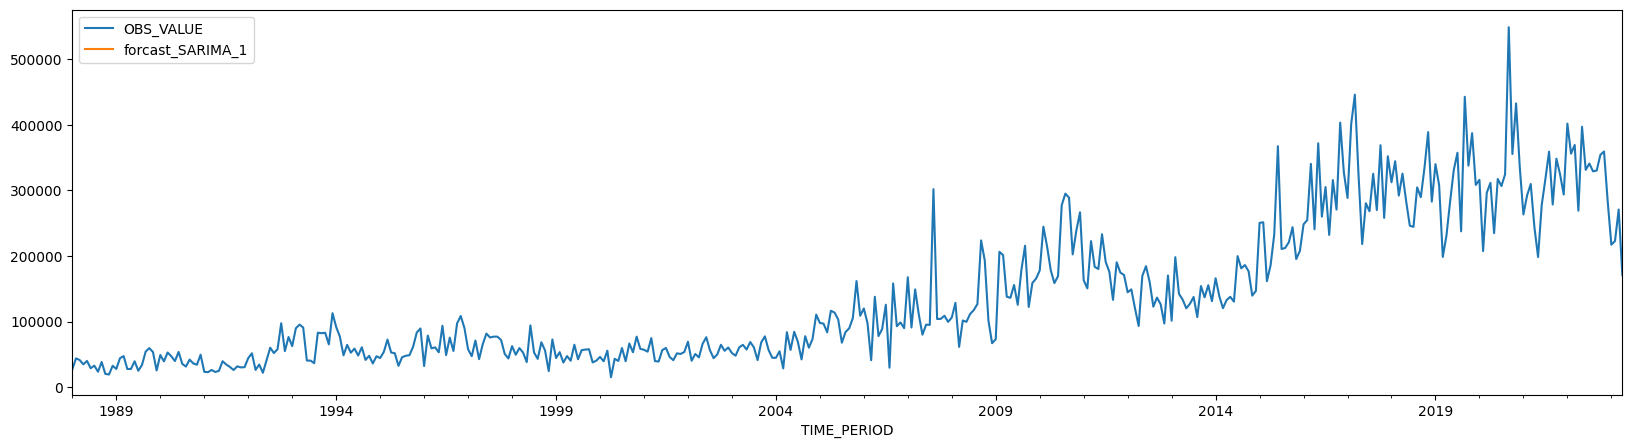

In [199]:
df['forcast_SARIMA_1']=result.predict(start=350, end=552)
df[['OBS_VALUE','forcast_SARIMA_1']].plot(figsize=(20, 5))

In [200]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,120)]
future_prediction = pd.DataFrame(index=date_list, columns= df.columns)
data = pd.concat([df, future_prediction])

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


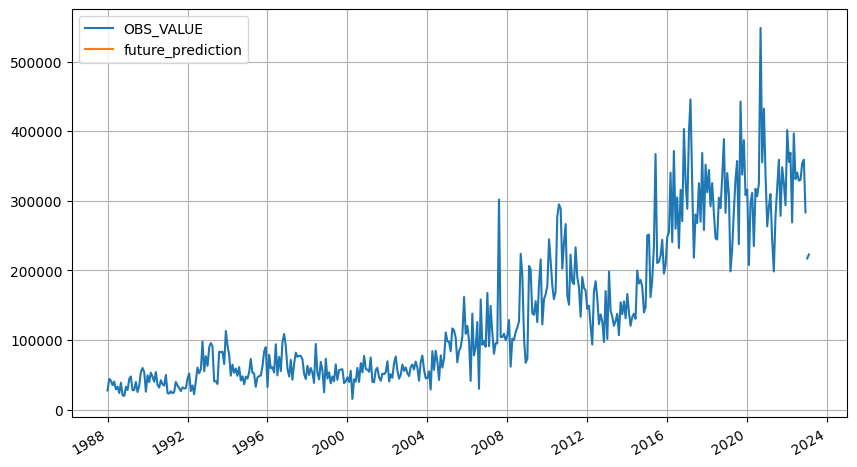

In [201]:
data['future_prediction']=result.predict(start=430, end=552, dynamic=True)
data[['OBS_VALUE','future_prediction']].plot(figsize=(10, 6))
plt.grid(True)

# Train / Test Split

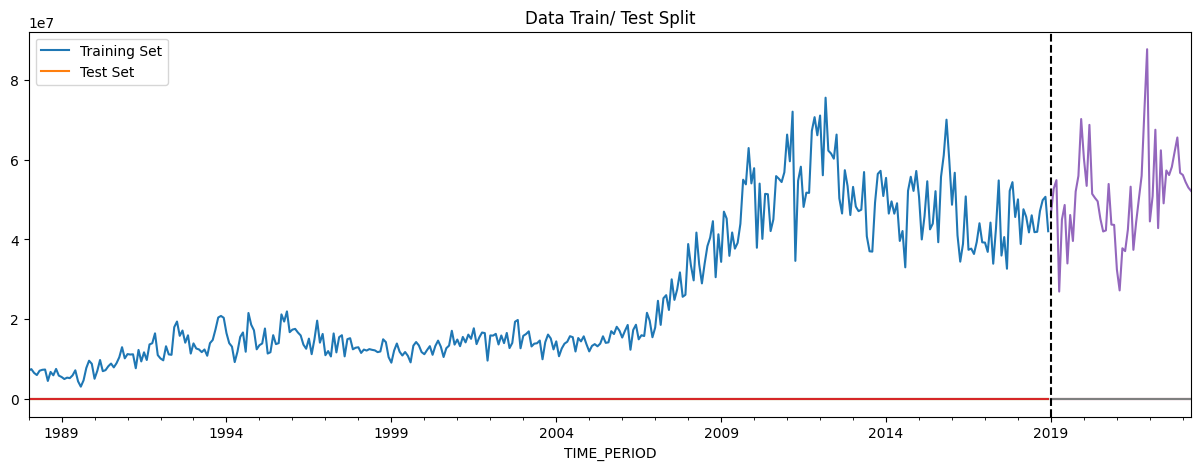

In [31]:
df = df.dropna()
train = df.loc[df.index < '2019-01']
test = df.loc[df.index >= '2019-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2019-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/ Test Split')
plt.show()

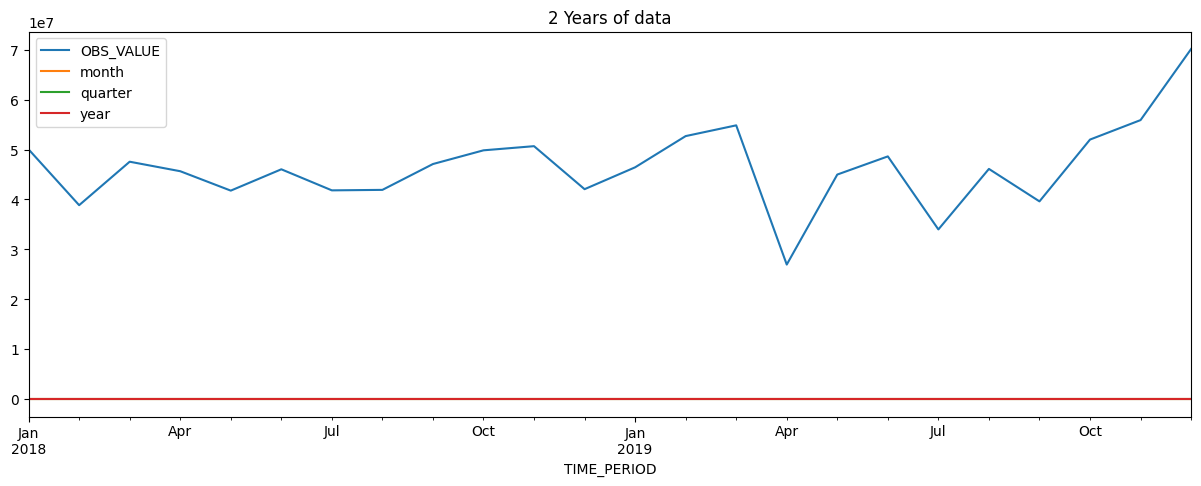

In [32]:
df.loc[(df.index >= '2018-01-01') & (df.index < '2020-01-01')].plot(figsize=(15, 5), title="2 Years of data")
plt.show()

# Feature Creation

In [33]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
    return df


In [34]:
df = create_features(df)

# Visualize our Feature / Target Relationships

<Axes: xlabel='month', ylabel='OBS_VALUE'>

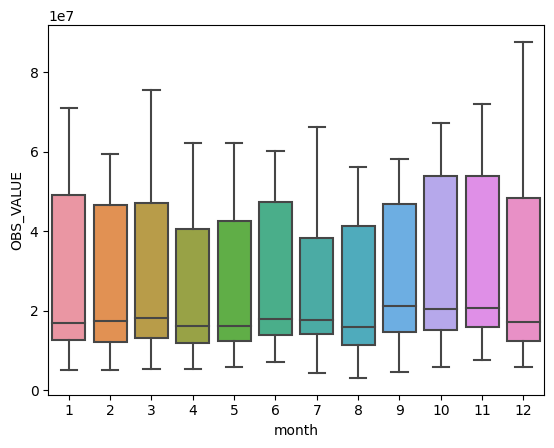

In [35]:
sns.boxplot(data=df, x='month', y='OBS_VALUE')

# Create Model

In [36]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'quarter', 'year']
TARGET = 'OBS_VALUE'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:31392207.30715	validation_1-rmse:52029055.75170
[100]	validation_0-rmse:28547455.12165	validation_1-rmse:47580637.50799
[200]	validation_0-rmse:25979018.17428	validation_1-rmse:44051426.80141
[300]	validation_0-rmse:23660409.67298	validation_1-rmse:40875920.37163
[400]	validation_0-rmse:21569219.80156	validation_1-rmse:38015758.87628
[500]	validation_0-rmse:19681970.95234	validation_1-rmse:35372755.76400
[600]	validation_0-rmse:17976583.65334	validation_1-rmse:32912099.44336
[700]	validation_0-rmse:16437842.00266	validation_1-rmse:30735905.25328
[800]	validation_0-rmse:15049724.38166	validation_1-rmse:28800629.17619
[900]	validation_0-rmse:13797483.57424	validation_1-rmse:27067114.80694
[999]	validation_0-rmse:12682799.28772	validation_1-rmse:25503559.08117


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

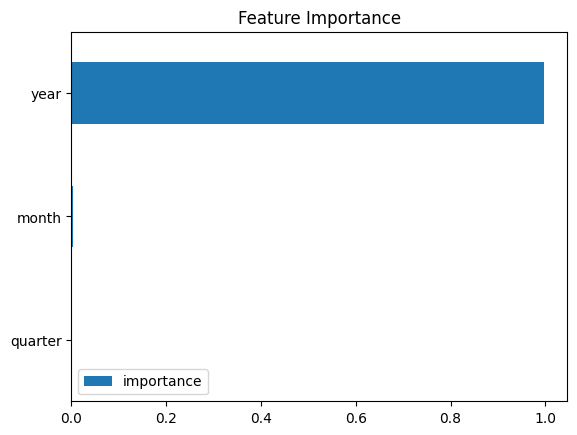

In [43]:
fi= pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [44]:
test['prediction'] = reg.predict(X_test)

In [45]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

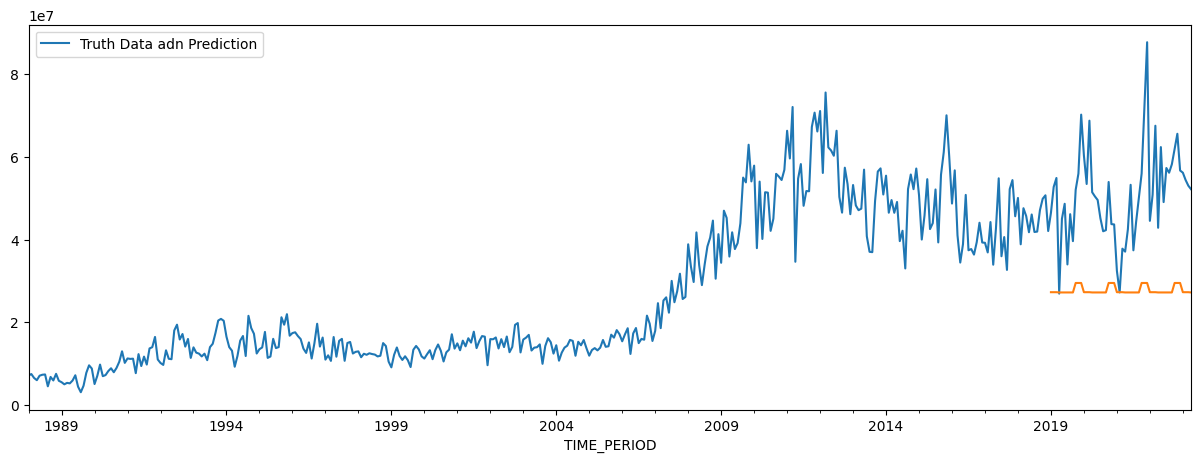

In [48]:
ax = df[['OBS_VALUE']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data adn Prediction'])
plt.show()